# **PamCrash dataset analysis**

Renault’s Engineering teams need to perform thousands of crash simulation each day for validating the safety of the next generations of vehicles. These simulations run on DIRE’s HPC Platform, which comprises about 100.000 CPU cores and a specialized server infrastructure. Each simulation takes multiple hours, sometimes days, on multiple servers used in parallel. A typical crash simulation takes about 8 hours on 180 CPU cores (5 servers). 

The annual cost of simulation is in the millions of euros, including infrastructure costs (servers) and license costs. It is thus crucial to optimize the way crash simulations are executed. 

To limit the cost, one possibility would be to slow down simulations when there’s not business impact. The scenario would be the following: if a simulation would complete outside of the engineering business hours, the simulation could be slowed down to complete right before the next work session (e.g. the day after or on Monday morning). 

Slowing down simulations saves money the same way driving slower saves gasoline for the same distance driven. Our usual cost metric is the number of core multiplied by the number of hours they are used, noted core.hours and the faster the simulation, the higher the number of core.hours spent for a given simulation, thus the higher the cost.

Automatically slowing down simulations running outside business hours should have no impact on the business. One prerequisite to automatically slow down these simulations is to be able to accurately predict the time they would take depending on the number of allocated servers, in order to predict the optimal number of cores to allocate to a simulation to ensure the business do not wait for the result. A simulation returned too early leads to an unnecessary extra cost; a simulation arriving too late leads to a loss of productivity for the engineer or the team waiting for the result. 

The objective of this challenge is to build a reliable and robust predictor that can be used in an algorithm for deciding the number of cores to be allocated to a simulation. The construction of the decision algorithm based on this predictor is outside the scope of this study. 

# Nouvelle section

### **Linking the notebook to the drive to access the dataset**



In [ ]:
# For generating the graphs we used a file hosted on Google Drive
# You might prefer using a URL or a local file. In this case, change the analyze_filename variable 
from google.colab import drive
drive.mount('/content/drive')
# File name to analyze
analyze_filename = "/content/drive/My Drive/Colab Notebooks/dataset_2020.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Loading the libraries required for the analysis and plots**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

### **Creating some usefull functions**

- **filter**: filter the dataframe by column value.

- **discretize**: transforms the values of a column from continuous to categorical. discretize( [10,11,15,19,21],[15,20]) returns [0,0,1,1,2] (0 for x<15, 1 for 15<=x<20, 2 for x>=20)

- **plot_pie**: draws a pie of the distribution of values of a given dataset

In [ ]:
def filter_aux(first, op, last):
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '==': operator.eq}
    return ops[op](first, last)

def filter(data, category, op, value):
    m = filter_aux(data[category], op, value)
    df = data[m]
    return df

def discretize(data, bins):
    data = np.asarray(data)
    data = np.digitize(data, bins)
    return data

def plot_pie(data, category, title, lb=None, ax1=None):
  dic = {}
  labels = list(set(data[category]))
  if lb == None:
    lb = labels
  sizes = []
  explode = np.zeros((len(labels)))
  for value in labels:
    nom = len(filter(data, category, "==", value))
    dic[value] = (nom/ len(data[category])) * 100
    sizes.append(dic[value])
  explode[sizes.index(max(sizes))] = 0.1
  explode = tuple(explode)
  fig1, ax1 = plt.subplots()
  wedges, autotexts =ax1.pie(sizes, explode=explode, textprops=dict(color="w"))
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax1.legend(wedges, lb ,
            title = title,
            loc = "center left",
            bbox_to_anchor = (1, 0, 0.5, 1))

  plt.setp(autotexts, size=8, weight="bold")

  plt.show()

### **What does our dataset look like?**


#### **Columns description**

We load the dataset and use pandas.head() to visualize a sample of the data. The following is a brief explanation of each column:

**JOBID**: The ID of each simulation (for information only).

**PERFORMANCE**: Type of crash performance (front crash, lateral, pedestrian, etc).

**PRECISION**: Numerical precision (simple or double). Impacts the performance of the simumation.

**RUNEND**: The duration of the simulation, in milliseconds.

**TIMESTEP**: A time step given by the user in ms. The maximum number of iterations is equal to RUNEND/TIMESTEP but the simulation can be stopped earlier.

**DATACHECK_TIME**: Execution time (in seconds) of the pre-computing phase, allowing us to check that the parameters are valid.

**NBNODES**: Total amount of nodes of the model. The 1D, 2D and 3D elements are composed of such nodes.

**NBELEM2D**: Number of 2D elements in the model. Each element composed of several nodes.

**ELAPSEDTIME**: Total time of the simulation, in seconds. This is the variable we're trying to predict.

**TZC**: Output column. Average time required per node per iteration. This column is given for advanced usage only because predicting TZC may help predicting ELAPSEDTIME.

In [ ]:
df = pd.read_csv(analyze_filename, sep=";")
df.head()

,JOBID,DAY,HOUR,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK+NTNU,MBS,RUNEND,TIMESTEP,NBNODES,NBELEM1D,NBELEM2D,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME,ELAPSEDTIME,TZC FINAL
0,829925,01/02/2019,10:04:18,2012.7,PEDESTRIAN,1,YES,NO,NO,NO,30.01,0.0007,1590622,2957,1479524,28133,HPC1,2,48,70.50,2920,0.0398
1,829727,01/02/2019,09:18:55,2012.7,UNKNOWN,1,YES,NO,NO,NO,200.01,0.0005,295906,2131,186901,195437,HPC1,2,48,31.20,6880,0.0431
2,829909,01/02/2019,10:03:08,2016.05,REAR,1,YES,NO,NO,NO,15.01,0.0005,4975242,17147,4904615,645960,HPC1,2,48,413.00,6560,0.0387
3,829842,01/02/2019,09:49:19,2012.7,UNKNOWN,2,YES,NO,NO,NO,200.10,0.0005,374553,1286,361806,357,HPC1,2,48,9.05,11200,0.0684
4,829844,01/02/2019,09:49:50,2012.7,UNKNOWN,1,YES,NO,NO,NO,320.01,0.0007,709006,1968,693741,515,HPC1,2,48,13.40,15300,0.0432


In [ ]:
# let's analyse the dataset structure ("object" means "string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89111 entries, 0 to 89110
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JOBID           89111 non-null  int64  
 1   DAY             89111 non-null  object 
 2   HOUR            89111 non-null  object 
 3   VERSION         89111 non-null  object 
 4   PERFORMANCE     89111 non-null  object 
 5   PRECISION       89111 non-null  int64  
 6   MPLINK          89111 non-null  object 
 7   NTNU            89111 non-null  object 
 8   MPLINK+NTNU     89111 non-null  object 
 9   MBS             89111 non-null  object 
 10  RUNEND          89111 non-null  float64
 11  TIMESTEP        89111 non-null  float64
 12  NBNODES         89111 non-null  int64  
 13  NBELEM1D        89111 non-null  int64  
 14  NBELEM2D        89111 non-null  int64  
 15  NBELEM3D        89111 non-null  int64  
 16  CLUSTER         89111 non-null  object 
 17  NBSERVERS       89111 non-null 

#### **A bit of statistical analysis on the data**


**Removing some useless columns**

The ID of the simulation, the day and the hour the simulation is started shouldn't have any impact on its run time so we remove it. "TZC FINAL" is an ouput column and we don't iterate on it in this baseline analysis.

In [ ]:
df = df.drop(["JOBID", "DAY", "HOUR", "TZC FINAL"], axis=1)

**Understanding the dataset**

We compute some statistical analysis functions on each column such as the mean, standard deviation, frequency, etc.

If a statistic isn't compatible with the column type, a "NaN" value will be dispalyed (such as mean or std for a categorical variable).
 

In [ ]:
df.describe(include="all")

,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK+NTNU,MBS,RUNEND,TIMESTEP,NBNODES,NBELEM1D,NBELEM2D,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME,ELAPSEDTIME
count,89111,89111,89111.000000,89111,89111,89111,89111,89111.000000,89111.000000,8.911100e+04,89111.000000,8.911100e+04,8.911100e+04,89111,89111.000000,89111.000000,89111.000000,89111.000000
unique,9,11,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,2016.05,UNKNOWN,NaN,YES,NO,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,HPC1,NaN,NaN,NaN,NaN
freq,64869,36891,NaN,73321,87438,80242,85283,NaN,NaN,NaN,NaN,NaN,NaN,58288,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.080170,NaN,NaN,NaN,NaN,234.139397,0.000494,2.741417e+06,10142.783270,2.525988e+06,6.192829e+05,NaN,2.826363,86.048277,223.005355,20768.712954
std,NaN,NaN,0.271557,NaN,NaN,NaN,NaN,1210.305221,0.000222,2.343590e+06,11047.308827,2.234719e+06,6.579853e+05,NaN,1.289671,56.742597,255.191336,19118.871922
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.410000,0.000001,5.040000e+02,0.000000,0.000000e+00,0.000000e+00,NaN,1.000000,36.000000,0.450000,1810.000000
25%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,60.100000,0.000500,8.364500e+05,2714.000000,7.120710e+05,2.028690e+05,NaN,2.000000,48.000000,39.600000,6260.000000
50%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,120.010000,0.000500,1.711695e+06,5773.000000,1.598437e+06,3.400300e+05,NaN,2.000000,48.000000,98.200000,14800.000000
75%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,200.000000,0.000500,4.790382e+06,16424.000000,4.544157e+06,9.124990e+05,NaN,3.000000,108.000000,400.000000,29200.000000


**Keeping only the HPC3 Cluster**

We'll focus only on HPC3 cluster in the training since this is the cluster on which the number of servers vary.

In [ ]:
HPC3 = df[df["CLUSTER"] == "HPC3"].drop(["CLUSTER"], axis=1).copy()

**Displaying the frequency of each value in every variable**

We display the frequency of each value for some variables that have a big impact on the ELAPSEDTIME variable.

In [ ]:
HPC3['PERFORMANCE'].value_counts()

FRONT         12133
UNKNOWN       10471
SIDE           2746
REAR           1888
RCAR           1695
WHEEL          1105
POLE            553
ECE             221
COCKPIT           4
PEDESTRIAN        1
Name: PERFORMANCE, dtype: int64

In [ ]:
HPC3['PRECISION'].value_counts()

1    29549
2     1268
Name: PRECISION, dtype: int64

In [ ]:
HPC3['VERSION'].value_counts()

2016.05     20839
2018.0.1     8883
2012.7        795
2016.06       139
2019.0.2       79
2019.0.1       75
2019            7
Name: VERSION, dtype: int64

In [ ]:
HPC3['NBSERVERS'].value_counts()

5    12896
3     8778
4     5121
6     3975
2       43
8        3
1        1
Name: NBSERVERS, dtype: int64

### **Graphical displays to help have an intuition about the data**




# Nouvelle section

In [ ]:
Pie_HPC3 = HPC3.copy()
# Modify the dataset to add the cardinality in the column name.
# Used only to display the pie charts
perf = HPC3["PERFORMANCE"].value_counts().to_dict()
nbserv = HPC3["NBSERVERS"].value_counts().to_dict()
for key,value in perf.items():
  perf[key] = key+" : "+str(perf[key])
for key,value in nbserv.items():
  nbserv[key] = str(key)+" : "+str(nbserv[key])
Pie_HPC3 = Pie_HPC3.replace({"PERFORMANCE":perf})
Pie_HPC3 = Pie_HPC3.replace({"NBSERVERS":nbserv})

#### **Data Distribution**

We use a PiePlot to display the proportion of each category of the PERFORMANCE and NBSERVERS variables.

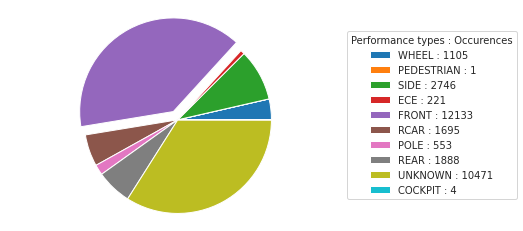

In [ ]:
plot_pie(Pie_HPC3, "PERFORMANCE", "Performance types : Occurences")
# TODO Donner les cardinalités, idem pour les graphes suivants

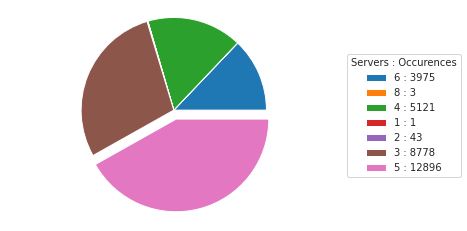

In [ ]:
plot_pie(Pie_HPC3,"NBSERVERS","Servers : Occurences")

**Discretization of continuous variables**

We transform continuous data into discretized/categorical data, in order to have an intuition about the proportion of each category using the PiePlot.

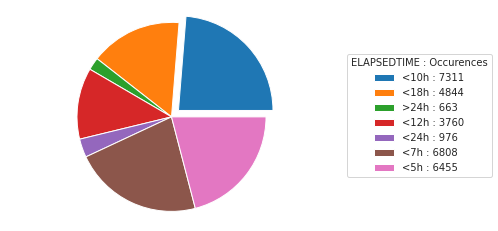

In [ ]:
Pie_HPC3["ELAPSEDTIME_disc"] = discretize(HPC3["ELAPSEDTIME"], [5*3600, 7*3600, 10*3600, 12*3600, 18*3600, 24*3600])
tab = ["<5h", "<7h", "<10h", "<12h", "<18h", "<24h", ">24h"]
elap = {}
for i in range(len(tab)):
  elap[i] = tab[i] + " : " + str(Pie_HPC3["ELAPSEDTIME_disc"].value_counts()[i])
Pie_HPC3 = Pie_HPC3.replace({"ELAPSEDTIME_disc":elap})
plot_pie(Pie_HPC3, "ELAPSEDTIME_disc", "ELAPSEDTIME : Occurences")

#### **Correlation between features**

HeatMap is a type of data visualization that shows the correlation between each two varaibles. In other words, we intend to see how much impact each variable has on the Output Variable (ELAPSEDTIME) and if there are two variables that tell the same information (getting rid of one of them in that case won't affect the results).

**Encoding categorical data**

We need to transform categorical data into numerical data in order for the HeatMap to be able to use it. For example, we can represent this set of values [Yes, No] as [1, 0]

In [ ]:
numerical = list(df.describe().columns)
categorical = [col for col in df.columns if col not in numerical]
for column in categorical:
  df[column] = LabelEncoder().fit_transform(df[column])

**Visualizing the HeatMap and correlation table**

The color of the field indicates the correlation's degree. Red is for positive correlation (incrementing variable1 increments variable2's value), Blue is negative correlation (incrementing varialbe1 decrements variable2's value), whilst white is neutral (no correlation = varialbe1 has no effect on variable2)


Text(0.0, 1.0, 'Correlation between features')

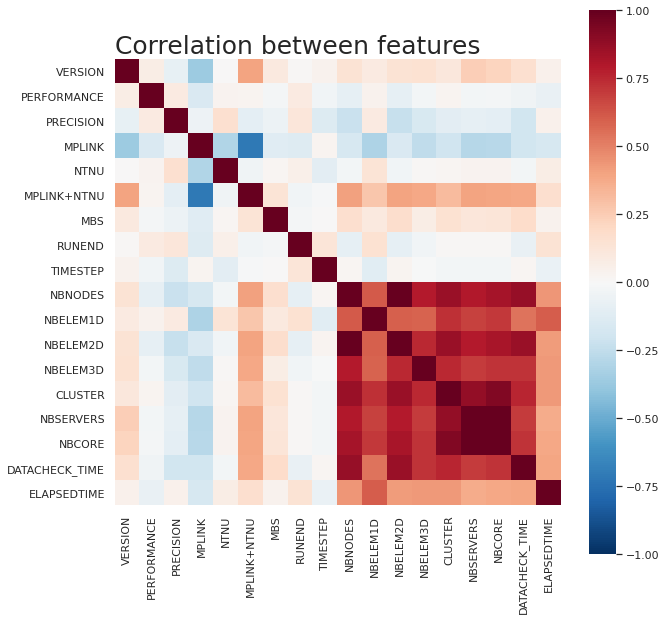

In [ ]:
correl = df.corr(method = 'pearson')
sns.set(rc={'figure.facecolor':'white'})
fig, ax = plt.subplots(figsize=(10,10)) 
correl_final = sns.heatmap(correl, vmin = -1, vmax = 1, center = 0, cmap = "RdBu_r", square = True, ax=ax)
correl_final.set_title('Correlation between features', fontsize = 25, loc = 'left')

In [ ]:
# Display the Heatmap's rounded values
round(correl,2)

,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK+NTNU,MBS,RUNEND,TIMESTEP,NBNODES,NBELEM1D,NBELEM2D,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME,ELAPSEDTIME
VERSION,1.00,0.08,-0.08,-0.36,0.00,0.40,0.10,0.01,0.04,0.15,0.09,0.14,0.15,0.11,0.24,0.22,0.16,0.05
PERFORMANCE,0.08,1.00,0.09,-0.15,0.04,0.03,-0.02,0.09,-0.04,-0.09,0.04,-0.09,-0.03,0.02,-0.03,-0.02,-0.04,-0.08
PRECISION,-0.08,0.09,1.00,-0.05,0.16,-0.10,-0.06,0.12,-0.13,-0.22,0.09,-0.23,-0.16,-0.10,-0.09,-0.10,-0.19,0.05
MPLINK,-0.36,-0.15,-0.05,1.00,-0.30,-0.72,-0.12,-0.13,0.03,-0.17,-0.31,-0.15,-0.25,-0.20,-0.29,-0.27,-0.19,-0.17
NTNU,0.00,0.04,0.16,-0.30,1.00,-0.05,0.02,0.06,-0.11,-0.03,0.13,-0.03,0.01,0.02,0.04,0.03,-0.03,0.08
MPLINK+NTNU,0.40,0.03,-0.10,-0.72,-0.05,1.00,0.14,-0.03,-0.01,0.41,0.27,0.40,0.39,0.32,0.40,0.39,0.39,0.16
MBS,0.10,-0.02,-0.06,-0.12,0.02,0.14,1.00,-0.02,0.00,0.17,0.10,0.18,0.08,0.15,0.12,0.13,0.19,0.05
RUNEND,0.01,0.09,0.12,-0.13,0.06,-0.03,-0.02,1.00,0.13,-0.09,0.15,-0.09,-0.04,0.01,0.01,0.01,-0.07,0.14
TIMESTEP,0.04,-0.04,-0.13,0.03,-0.11,-0.01,0.00,0.13,1.00,0.02,-0.11,0.03,-0.00,-0.03,-0.03,-0.03,0.02,-0.07
NBNODES,0.15,-0.09,-0.22,-0.17,-0.03,0.41,0.17,-0.09,0.02,1.00,0.61,1.00,0.79,0.87,0.80,0.83,0.87,0.44
